In [ ]:
!pip install torch torchvision transformers pillow matplotlib numpy tqdm

ERROR: Could not find a version that satisfies the requirement tqdmS (from versions: none)
ERROR: No matching distribution found for tqdmS


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.spectral_norm import spectral_norm

In [ ]:

# Generator
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, ngf):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + noise_dim, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1),
            nn.Tanh()  # Output image values in range [-1, 1]
        )

    def forward(self, text_embedding, noise):
        x = torch.cat([text_embedding, noise], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)  # Reshape for deconvolution
        img = self.deconv(x)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, text_dim, ndf):
        super(Discriminator, self).__init__()
        self.image_branch = nn.Sequential(
            spectral_norm(nn.Conv2d(3, ndf, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.text_branch = nn.Sequential(
            nn.Linear(text_dim, ndf * 8),
            nn.ReLU(True)
        )
        self.joint_branch = nn.Sequential(
            nn.Conv2d(ndf * 8 + ndf * 8, ndf * 8, 3, 1, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0)
        )

    def forward(self, img, text_embedding):
        img_features = self.image_branch(img)
        text_features = self.text_branch(text_embedding).unsqueeze(2).unsqueeze(3)
        text_features = text_features.expand(-1, -1, img_features.size(2), img_features.size(3))
        joint_features = torch.cat([img_features, text_features], dim=1)
        validity = self.joint_branch(joint_features)
        return validity.view(-1, 1).squeeze(1)


In [ ]:
def train_dfgan(generator, discriminator, dataloader, text_dim, noise_dim, device, num_epochs=100):
    # Optimizers
    optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in range(num_epochs):
        for batch in dataloader:
            # Prepare data
            real_images = batch['image'].to(device)
            captions = batch['caption_embedding'].to(device)
            batch_size = real_images.size(0)

            # Train Discriminator
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = generator(captions, noise)
            real_validity = discriminator(real_images, captions)
            fake_validity = discriminator(fake_images.detach(), captions)
            d_loss = criterion(real_validity, torch.ones_like(real_validity)) + \
                     criterion(fake_validity, torch.zeros_like(fake_validity))
            optim_D.zero_grad()
            d_loss.backward()
            optim_D.step()

            # Train Generator
            fake_validity = discriminator(fake_images, captions)
            g_loss = criterion(fake_validity, torch.ones_like(fake_validity))
            optim_G.zero_grad()
            g_loss.backward()
            optim_G.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return generator


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After mounting, you can access files under '/content/drive/My Drive/'
print("Google Drive is now connected!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is now connected!


In [ ]:
import pickle  # Ensure this is imported
from torch.utils.data import DataLoader, Dataset

class FlickrDataset(Dataset):
    def __init__(self, preprocessed_data):
        self.data = preprocessed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'image': self.data[idx]['image'],
            'caption_embedding': self.data[idx]['caption_embedding']
        }

# Load preprocessed data
with open('/content/drive/MyDrive/projj/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

dataset = FlickrDataset(preprocessed_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
text_dim = 768  # BERT embedding size
noise_dim = 100  # Random noise size
ngf = 64  # Generator feature size
ndf = 64  # Discriminator feature size

generator = Generator(text_dim, noise_dim, ngf).to(device)
discriminator = Discriminator(text_dim, ndf).to(device)

# Train the model
trained_generator = train_dfgan(generator, discriminator, dataloader, text_dim, noise_dim, device, num_epochs=100)


Epoch [1/100], D Loss: 0.4776, G Loss: 4.8858
Epoch [2/100], D Loss: 0.8538, G Loss: 4.4019
Epoch [3/100], D Loss: 0.2645, G Loss: 6.2451
Epoch [4/100], D Loss: 0.4190, G Loss: 3.3921
Epoch [5/100], D Loss: 0.7401, G Loss: 2.3323
Epoch [6/100], D Loss: 0.6279, G Loss: 2.6076
Epoch [7/100], D Loss: 0.5657, G Loss: 2.5542
Epoch [8/100], D Loss: 0.6798, G Loss: 2.6100
Epoch [9/100], D Loss: 0.5529, G Loss: 3.3633
Epoch [10/100], D Loss: 0.3611, G Loss: 5.2181
Epoch [11/100], D Loss: 0.3019, G Loss: 3.2039
Epoch [12/100], D Loss: 0.2161, G Loss: 5.6418
Epoch [13/100], D Loss: 0.5377, G Loss: 3.6318
Epoch [14/100], D Loss: 0.1683, G Loss: 5.3273
Epoch [15/100], D Loss: 0.1231, G Loss: 5.0390
Epoch [16/100], D Loss: 0.1075, G Loss: 5.1984
Epoch [17/100], D Loss: 0.3389, G Loss: 5.0431
Epoch [18/100], D Loss: 0.9601, G Loss: 1.4395
Epoch [19/100], D Loss: 0.1236, G Loss: 5.5637
Epoch [20/100], D Loss: 0.1458, G Loss: 2.6049
Epoch [21/100], D Loss: 1.4269, G Loss: 14.8435
Epoch [22/100], D Los

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

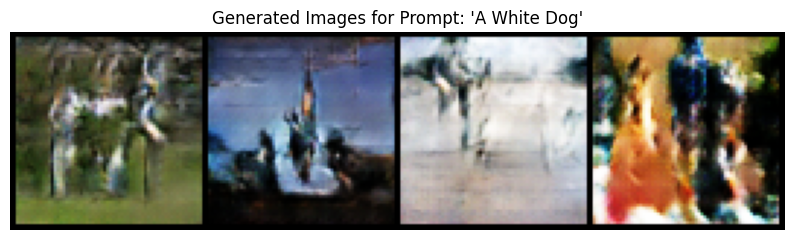

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer  # Use CLIP for text encoding
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt


class TextToImagePipeline:
    def __init__(self, generator, text_encoder, tokenizer, device, noise_dim, text_dim):
        self.generator = generator
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.device = device
        self.noise_dim = noise_dim
        self.text_dim = text_dim

        # Add a linear layer to map text embeddings to the expected dimension
        self.embedding_mapper = torch.nn.Linear(text_encoder.config.hidden_size, text_dim).to(device)

    def generate_image(self, text_prompt, num_samples=1):
        # Encode the text prompt to embeddings
        inputs = self.tokenizer(text_prompt, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad():
            text_embeddings = self.text_encoder(**inputs).last_hidden_state.mean(dim=1)

        # Map text embeddings to the expected dimension
        text_embeddings = self.embedding_mapper(text_embeddings)

        # Repeat the text embeddings to match the number of samples
        text_embeddings = text_embeddings.repeat(num_samples, 1)

        # Generate random noise
        noise = torch.randn(num_samples, self.noise_dim, device=self.device)

        # Generate images
        with torch.no_grad():
            generated_images = self.generator(text_embeddings, noise)

        return generated_images




# Load CLIP text encoder and tokenizer
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Initialize the updated pipeline
pipeline = TextToImagePipeline(trained_generator, text_encoder, tokenizer, device, noise_dim, text_dim)

# Generate images
text_prompt = "A White Dog"
num_samples = 4
generated_images = pipeline.generate_image(text_prompt, num_samples)

# Display generated images
grid = vutils.make_grid(generated_images, normalize=True, scale_each=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title(f"Generated Images for Prompt: '{text_prompt}'")
plt.show()

In [ ]:
import pickle
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Define the dataset class
class FlickrDataset(Dataset):
    def __init__(self, preprocessed_data):
        """
        Initializes the dataset with the preprocessed data.
        :param preprocessed_data: List of dictionaries with 'image' and 'caption_embedding' keys.
        """
        self.data = preprocessed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'image': self.data[idx]['image'],
            'caption_embedding': self.data[idx]['caption_embedding']
        }

# Adjust this path to match your uploaded file
file_path = '/content/drive/MyDrive/projj/preprocessed_data.pkl'  # Make sure this matches the uploaded dataset file name

# Load the preprocessed data
try:
    with open(file_path, 'rb') as f:
        preprocessed_data = pickle.load(f)

    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please ensure the correct file is uploaded.")
    raise

# Create the dataset and dataloader
dataset = FlickrDataset(preprocessed_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Ensure `generator` and `discriminator` models are defined before fine-tuning
def fine_tune_dfgan(generator, discriminator, dataloader, text_dim, noise_dim, device, num_epochs=100, lr=0.0001):
    """
    Fine-tune the generator and discriminator.
    """
    optim_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        for batch in dataloader:
            real_images = batch['image'].to(device)
            captions = batch['caption_embedding'].to(device)
            batch_size = real_images.size(0)

            # Train Discriminator
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = generator(captions, noise)
            real_validity = discriminator(real_images, captions)
            fake_validity = discriminator(fake_images.detach(), captions)

            d_loss_real = criterion(real_validity, torch.ones_like(real_validity))
            d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity))
            d_loss = d_loss_real + d_loss_fake

            optim_D.zero_grad()
            d_loss.backward()
            optim_D.step()

            # Train Generator
            fake_validity = discriminator(fake_images, captions)
            g_loss = criterion(fake_validity, torch.ones_like(fake_validity))

            optim_G.zero_grad()
            g_loss.backward()
            optim_G.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return generator, discriminator

# Fine-tune the models
text_dim = 768  # Example text embedding size
noise_dim = 100  # Example noise dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fine_tuned_generator, fine_tuned_discriminator = fine_tune_dfgan(
    generator, discriminator, dataloader, text_dim, noise_dim, device, num_epochs=100
)

# Save the fine-tuned models
save_dir = '/content/preprocessed_data.pkl'
os.makedirs(save_dir, exist_ok=True)

# Save the generator
generator_path = os.path.join(save_dir, 'fine_tuned_generator.pth')
torch.save(fine_tuned_generator.state_dict(), generator_path)
print(f"Generator model saved at {generator_path}")

# Save the discriminator
discriminator_path = os.path.join(save_dir, 'fine_tuned_discriminator.pth')
torch.save(fine_tuned_discriminator.state_dict(), discriminator_path)
print(f"Discriminator model saved at {discriminator_path}")

# Assuming lr (learning rate) and betas are defined earlier in your code
lr = 0.0002
betas = (0.5, 0.999)

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Save Optimizer States (Optional)
torch.save(optim_G.state_dict(), '/content/drive/MyDrive/projj/optimizer_G_state.pth')
torch.save(optim_D.state_dict(), '/content/drive/MyDrive/projj/optimizer_D_state.pth')

# Save Important Hyperparameters
config = {
    'text_dim': 768,
    'noise_dim': 100,
    'ngf': 64,
    'ndf': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

import json
with open('/content/drive/MyDrive/projj/config.json', 'w') as f:
    json.dump(config, f)



Dataset loaded successfully!
Epoch [1/100], D Loss: 0.0260, G Loss: 8.4015
Epoch [2/100], D Loss: 0.0515, G Loss: 9.7701
Epoch [3/100], D Loss: 0.0079, G Loss: 7.1549
Epoch [4/100], D Loss: 0.0090, G Loss: 7.7210
Epoch [5/100], D Loss: 0.0034, G Loss: 7.1041
Epoch [6/100], D Loss: 0.0062, G Loss: 6.7922
Epoch [7/100], D Loss: 0.0310, G Loss: 6.8071
Epoch [8/100], D Loss: 0.0026, G Loss: 7.3521
Epoch [9/100], D Loss: 0.4078, G Loss: 9.6449
Epoch [10/100], D Loss: 0.0330, G Loss: 6.4687
Epoch [11/100], D Loss: 0.0015, G Loss: 9.5090
Epoch [12/100], D Loss: 0.0044, G Loss: 8.0171
Epoch [13/100], D Loss: 0.0008, G Loss: 12.6005
Epoch [14/100], D Loss: 0.0033, G Loss: 7.7610
Epoch [15/100], D Loss: 0.0054, G Loss: 7.2515
Epoch [16/100], D Loss: 0.0560, G Loss: 12.1706
Epoch [17/100], D Loss: 0.0279, G Loss: 6.9120
Epoch [18/100], D Loss: 0.0166, G Loss: 7.2353
Epoch [19/100], D Loss: 0.0090, G Loss: 7.7222
Epoch [20/100], D Loss: 0.0147, G Loss: 7.3283
Epoch [21/100], D Loss: 0.0111, G Loss

<ipython-input-17-b2009154538a>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/preprocessed_data.pkl/fine_tuned_generator.p

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

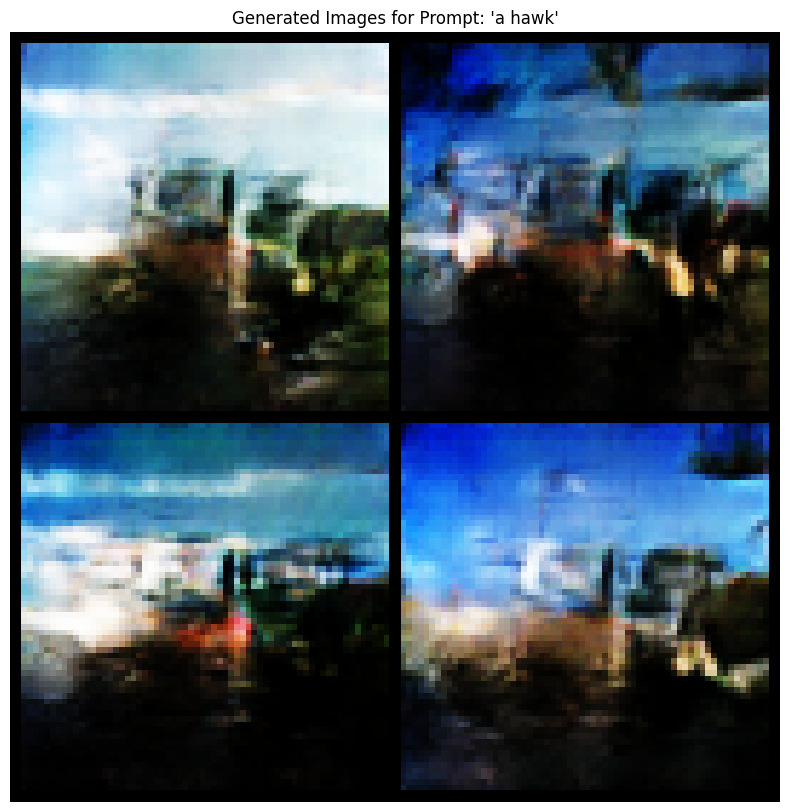

In [ ]:
# Install Required Libraries (if not already installed)
!pip install torch torchvision transformers matplotlib

import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import json
import os

# Load Config
with open('/content/drive/MyDrive/projj/config.json', 'r') as f:
    config = json.load(f)

device = torch.device(config['device'])

# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, ngf):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + noise_dim, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, text_embedding, noise):
        x = torch.cat([text_embedding, noise], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        img = self.deconv(x)
        return img

# Load Generator Model
generator = Generator(config['text_dim'], config['noise_dim'], config['ngf']).to(device)
generator.load_state_dict(torch.load('/content/preprocessed_data.pkl/fine_tuned_generator.pth', map_location=device))
generator.eval()

# Load Text Encoder
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# Pipeline for Image Generation
class DFGANPipeline:
    def __init__(self, generator, tokenizer, bert_model, device):
        self.generator = generator
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.device = device

    def generate_embedding(self, text_prompt):
        with torch.no_grad():
            inputs = self.tokenizer(text_prompt, return_tensors="pt", padding=True, truncation=True).to(self.device)
            embedding = self.bert_model(**inputs).pooler_output
        return embedding

    def generate_image(self, text_prompt, num_samples):
        text_embedding = self.generate_embedding(text_prompt).repeat(num_samples, 1)
        noise = torch.randn(num_samples, config['noise_dim'], device=self.device)
        with torch.no_grad():
            generated_images = self.generator(text_embedding, noise)
        return generated_images

# Initialize Pipeline
pipeline = DFGANPipeline(generator, tokenizer, bert_model, device)

# Example Inference
text_prompt = "a hawk"
num_samples = 4
generated_images = pipeline.generate_image(text_prompt, num_samples)

# Display Generated Images
grid = vutils.make_grid(generated_images, normalize=True, scale_each=True, nrow=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title(f"Generated Images for Prompt: '{text_prompt}'")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import json
from transformers import BertTokenizer, BertModel
import random
import torchvision.utils as vutils

# Dataset for Images (updated to use the FlickrDataset class)
class ImageDataset(Dataset):
    def __init__(self, images):
        """
        Dataset class for images.
        :param images: List of PyTorch tensors representing images.
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]


# Helper Functions
def preprocess_images(images, device, resize=299):
    """
    Normalize and resize images for Inception v3 model.
    :param images: List of PyTorch tensors of shape [C, H, W].
    :param device: Torch device.
    :param resize: Resize dimensions (default: 299 for Inception).
    :return: Tensor of preprocessed images.
    """
    transform = torch.nn.Sequential(
        Resize((resize, resize)),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    )
    return torch.stack([transform(image) for image in images]).to(device)


def calculate_activation_statistics(images, model, device):
    """
    Calculate the activation statistics (mean, covariance) for a batch of images.
    :param images: Tensor of shape [N, C, H, W].
    :param model: Inception v3 model.
    :param device: Torch device.
    :return: Mean and covariance matrix of the activations.
    """
    model.eval()
    with torch.no_grad():
        features = model(images).detach().cpu().numpy()

    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


def compute_fid(real_images, fake_images, device, batch_size=32):
    """
    Compute the Fréchet Inception Distance (FID) between real and generated images.
    :param real_images: List of real image tensors.
    :param fake_images: List of generated image tensors.
    :param device: Torch device.
    :param batch_size: Batch size for processing.
    :return: FID score.
    """
    # Load Inception model
    weights = Inception_V3_Weights.IMAGENET1K_V1
    inception = inception_v3(weights=weights, transform_input=False).to(device)
    inception.fc = torch.nn.Identity()  # Use pre-logits feature activations
    inception.eval()

    # Create dataloaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Compute activations
    real_activations = []
    fake_activations = []

    for real_batch in tqdm(real_loader, desc="Processing Real Images"):
        real_batch = preprocess_images(real_batch, device)
        real_features = inception(real_batch)
        real_activations.append(real_features.detach().cpu().numpy())  # Fix: detach and then convert to numpy

    for fake_batch in tqdm(fake_loader, desc="Processing Fake Images"):
        fake_batch = preprocess_images(fake_batch, device)
        fake_features = inception(fake_batch)
        fake_activations.append(fake_features.detach().cpu().numpy())  # Fix: detach and then convert to numpy

    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    # Compute FID
    diff = mu_real - mu_fake
    covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid


def compute_inception_score(images, device, num_splits=10, batch_size=32):
    """
    Compute the Inception Score (IS) for a set of images.
    :param images: List of generated image tensors.
    :param device: Torch device.
    :param num_splits: Number of splits for IS computation.
    :param batch_size: Batch size for processing.
    :return: Mean and standard deviation of IS.
    """
    # Load Inception model
    weights = Inception_V3_Weights.IMAGENET1K_V1
    inception = inception_v3(weights=weights, transform_input=False).to(device)
    inception.eval()

    # Create dataloader
    dataset = ImageDataset(images)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Processing Images"):
            batch = preprocess_images(batch, device)
            logits = inception(batch)
            preds.append(F.softmax(logits, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Compute IS
    split_scores = []
    for k in range(num_splits):
        part = preds[k * (len(preds) // num_splits): (k + 1) * (len(preds) // num_splits)]
        py = np.mean(part, axis=0)
        scores = [F.kl_div(torch.tensor(np.log(p)), torch.tensor(py), reduction='sum').item() for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


# DFGAN Image Generation Setup
class DFGANPipeline:
    def __init__(self, generator, tokenizer, bert_model, device):
        self.generator = generator
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.device = device

    def generate_embedding(self, text_prompt):
        with torch.no_grad():
            inputs = self.tokenizer(text_prompt, return_tensors="pt", padding=True, truncation=True).to(self.device)
            embedding = self.bert_model(**inputs).pooler_output
        return embedding

    def generate_image(self, text_prompt, num_samples):
        text_embedding = self.generate_embedding(text_prompt).repeat(num_samples, 1)
        noise = torch.randn(num_samples, config['noise_dim'], device=self.device)
        with torch.no_grad():
            generated_images = self.generator(text_embedding, noise)
        return generated_images


# Initialize DF-GAN Pipeline
with open('/content/drive/MyDrive/projj/config.json', 'r') as f:
    config = json.load(f)

device = torch.device(config['device'])
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
generator = Generator(config['text_dim'], config['noise_dim'], config['ngf']).to(device)

# Fix for the FutureWarning by setting weights_only=False, removing unnecessary argument
generator.load_state_dict(torch.load('/content/preprocessed_data.pkl/fine_tuned_generator.pth', map_location=device))

pipeline = DFGANPipeline(generator, tokenizer, bert_model, device)

# List of Random Text Prompts
random_text_prompts = [
    "a sunny day at the beach",
    "a cat sitting on a windowsill",
    "a person reading a book in a park",
    "a futuristic cityscape",
    "a beautiful mountain landscape",
    "a dog running through a field",
    "a group of people playing soccer",
    "a delicious pizza with toppings",
    "a bustling street market at night",
    "a scenic view of a river in autumn",
    "a couple walking through a forest trail",
    "a car driving down a road at sunset",
    "a person riding a bicycle in the city",
    "a dog playing with a ball in the yard",
    "a person kayaking on a calm lake",
    "a vibrant garden full of flowers",
    "a snowy mountain peak with skiers",
    "a field of sunflowers under a clear sky",
    "a busy street corner in New York",
    "a colorful rainbow after a storm",
    "a family having a picnic in the park",
    "a person playing guitar by a campfire",
    "a majestic eagle soaring over mountains",
    "a sunset over the ocean",
    "a tranquil beach with clear turquoise water",
    "a couple dancing under the stars",
    "a person swimming in a crystal-clear pool",
    "a street vendor selling fresh fruit",
    "a beautiful waterfall in a rainforest",
    "a large campfire in the middle of the forest",
    "a vintage train traveling through the countryside",
    "a skateboarder doing tricks at a skate park",
    "a person painting on a canvas outdoors",
    "a peaceful zen garden with rocks and sand",
    "a busy café with people working on laptops",
    "a colorful hot air balloon in the sky",
    "a chef preparing a gourmet meal in a kitchen",
    "a hiker standing on top of a mountain",
    "a sunset over a calm river",
    "a person walking a dog in the park",
    "a skateboarder cruising down a city street",
    "a person enjoying a coffee at a café",
    "a romantic dinner setting with candles",
    "a rainbow over a lush green valley",
    "a person playing chess at a park bench",
    "a bicycle parked against a brick wall",
    "a child playing with a toy car",
    "a couple sitting on a bench in a garden",
    "a group of people at a beach bonfire",
    "a person reading a book by a fireplace",
    "a vibrant city skyline at night",
    "a football game in a stadium",
    "a street artist painting a mural on a wall",
    "a surfer riding a wave",
    "a snowy landscape with a cabin",
    "a close-up of a cup of hot chocolate",
    "a couple hiking through a forest",
    "a sunset over a rural farmhouse",
    "a person sitting on a rooftop watching the city",
    "a busy train station during rush hour",
    "a futuristic robot walking in a city",
    "a bird flying over a desert landscape",
    "a group of children playing in a playground",
    "a person practicing yoga by the ocean",
    "a large aquarium with colorful fish",
    "a couple holding hands at a carnival",
    "a city park during autumn",
    "a train traveling through a snowy mountain pass",
    "a person meditating by a river",
    "a chef preparing sushi in a restaurant",
    "a luxury yacht on the ocean",
    "a hot air balloon ride over the countryside",
    "a tropical beach with palm trees",
    "a person working on a laptop in a café",
    "a person reading under a tree",
    "a group of friends hiking in the mountains",
    "a large family reunion at a picnic",
    "a couple walking along a beach at dusk",
    "a young child playing with a kite",
    "a coffee shop with cozy seating",
    "a boat floating on a calm lake at sunrise",
    "a person fishing from a small boat",
    "a row of colorful houses along a street",
    "a person taking a photo of the sunset",
    "a cozy cabin in the woods",
    "a couple riding horses in the countryside",
    "a person sitting in a hammock in a garden",
    "a bustling city street at night",
    "a dog lying on a blanket in the sun",
    "a quiet library with shelves of books",
    "a skateboarder practicing at a skatepark",
    "a person jogging in a park during fall",
    "a busy shopping street in a city center",
    "a beautiful butterfly on a flower",
    "a person enjoying a sunset with a view",
    "a street performer playing music on a corner",
    "a family having a barbecue in the backyard",
    "a hiker resting on a rock overlooking a valley",
    "a couple on a romantic gondola ride",
    "a person holding a bouquet of flowers",
    "a crowd of people at a music concert",
    "a person practicing archery in the woods",
    "a farmer working in a field at dawn",
    "a person watching a thunderstorm from inside",
    "a sunset over a tropical island",
    "a family enjoying an amusement park ride",
    "a mountain biker riding down a trail",
    "a couple walking through a vineyard",
    "a group of people playing beach volleyball",
    "a person sipping tea in a cozy room",
    "a skier going down a snowy slope",
    "a group of friends sitting around a campfire",
    "a street lined with autumn trees",
    "a couple enjoying a boat ride on a lake",
    "a person taking a selfie at a landmark",
    "a cityscape with tall skyscrapers",
    "a cute puppy playing in the snow",
    "a young couple sitting at a café table",
    "a person jogging on a beach at sunrise",
    "a bird perched on a tree branch",
    "a family enjoying a picnic by the river",
    "a person walking through a field of flowers",
    "a street market with vendors selling goods",
    "a person painting a landscape outdoors",
    "a majestic lion standing in a savannah",
    "a person climbing a rock wall indoors",
    "a couple exploring a cave",
    "a child building a sandcastle at the beach",
    "a person reading on a park bench",
    "a busy intersection in a big city",
    "a family playing in the snow",
    "a street lined with Christmas lights",
    "a person playing with a dog in the yard",
    "a couple dining at a rooftop restaurant",
    "a person walking along a cliff edge",
    "a city skyline with a setting sun",
    "a person enjoying an ice cream cone",
    "a beautiful sunset over a mountain range",
    "a group of people dancing at a party",
    "a person riding a horse through a field",
    "a child playing in a treehouse",
    "a person watching fireworks on New Year's Eve",
    "a group of friends on a road trip",
    "a person enjoying a peaceful evening walk",
    "a group of children playing soccer",
    "a man with a camera in a city street",
    "a person exploring an old castle",
    "a couple enjoying a wine tasting",
    "a person painting a mural on a wall",
    "a group of people in a park during spring",
    "a person swimming in an outdoor pool",
    "a family of ducks swimming in a pond",
    "a couple looking at stars through a telescope",
    "a person flying a drone over the ocean",
    "a child riding a bicycle through a neighborhood",
    "a couple standing on a pier overlooking the water",
    "a couple enjoying a coffee in a park",
    "a person enjoying the sunrise in the mountains",
    "a city park with flowers and trees",
    "a group of friends having a picnic",
    "a person reading a newspaper at a café",
    "a person walking through a snow-covered forest",
    "a person painting a landscape with watercolors",
    "a large family having a barbecue",
    "a person enjoying a warm bath by candlelight",
    "a group of tourists exploring a city",
    "a couple taking a selfie in front of a monument",
    "a beautiful garden with a stone path",
    "a group of friends playing volleyball on the beach",
    "a person enjoying a hot cup of coffee in winter",
    "a group of people taking a walk in the park",
    "a family playing games in the living room",
    "a person sitting by a fireplace with a book",
    "a person running through a field of wheat",
    "a person enjoying a cup of tea in a cozy room",
    "a group of people enjoying a beach day",
    "a person flying a kite in a meadow",
    "a family decorating a Christmas tree",
    "a person enjoying a sunset on the beach",
    "a woman walking through a botanical garden",
    "a couple having a romantic dinner at sunset",
    "a person playing a piano in a quiet room",
    "a dog jumping into a pool",
    "a family watching a movie together at home",
    "a person taking a walk in a city at night",
    "a person reading a book in a cozy café",
    "a beautiful sunset over a city",
    "a couple relaxing on a tropical beach",
    "a person riding a scooter in the city",
    "a child jumping in a puddle on a rainy day",
    "a person cycling through a countryside road",
    "a person watching a sunset from a mountain peak",
    "a person eating ice cream in a park",
    "a person sitting on a park bench with a dog",
    "a family enjoying a trip to the zoo",
    "a person kayaking through a mangrove forest",
    "a person walking along a path in a nature reserve",
    "a person exploring a beach cave",
    "a couple having a romantic dinner by the beach",
    "a person walking through a foggy forest",
    "a family building a snowman",
    "a couple holding hands on a beach at sunset",
    "a person riding a horse along the coast",
    "a person taking a hike in the mountains",
    "a person having breakfast on a terrace",
    "a group of people kayaking on a river",
    "a person sitting by a mountain lake",
    "a child playing with a pet rabbit",
    "a person climbing a mountain trail",
    "a couple enjoying a boat trip on a river",
    "a couple having a picnic by a lakeside",
    "a person walking down a long path in a forest",
    "a group of hikers reaching a mountain summit",
    "a person building a treehouse in the woods",
    "a large hot air balloon flying over a valley",
    "a family watching a sunset at the beach",
    "a couple looking at the stars from a hilltop",
    "a group of people hiking along a river",
    "a person riding a motorcycle down a rural road"
]


# Generate Fake Images from Random Text Prompts
num_samples_per_prompt = 25  # Number of samples per prompt
all_fake_images = []

for prompt in random_text_prompts:
    generated_images = pipeline.generate_image(prompt, num_samples_per_prompt)
    all_fake_images.extend(generated_images)

# Convert generated images to list for FID/IS calculation
fake_images = [img for img in all_fake_images]

# Assuming preprocessed_data contains the real images
real_images = [item['image'] for item in preprocessed_data]  # Assuming preprocessed_data is loaded earlier

# Compute FID
fid_score = compute_fid(real_images, fake_images, device)
print(f"FID Score: {fid_score:.4f}")

# Compute Inception Score
mean_is, std_is = compute_inception_score(fake_images, device)
print(f"Inception Score: Mean = {mean_is:.4f}, Std = {std_is:.4f}")


<ipython-input-19-43e5dc1d7e62>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/preprocessed_data.pkl/fine_tuned_generator.

FID Score: 89.9426


Processing Images: 100%|██████████| 172/172 [00:22<00:00,  7.81it/s]


Inception Score: Mean = 3.1615, Std = 0.0643


Images generated through Diffusion model (API)

In [ ]:
!pip install googletrans==4.0.0-rc1
from diffusers import StableDiffusionPipeline
from googletrans import Translator
import torch
import os
import re
from transformers import pipeline

# Load the Stable Diffusion pipeline
def load_model():
    print("Downloading and loading Stable Diffusion model...")
    # pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)
    # pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe.to(device)
    print(f"Model loaded on {device}.")
    return pipe

# Translate text prompt to English
def translate_prompt(prompt):
    translator = Translator()
    translated = translator.translate(prompt, src="auto", dest="en").text
    print(f"Translated prompt: {translated}")
    return translated

# Enrich the prompt for better descriptions
def enrich_prompt(prompt):
    print("Enhancing the prompt...")
    text_generator = pipeline("text2text-generation", model="t5-small")
    enriched_prompt = text_generator(f"Improve this description: {prompt}", max_length=50, do_sample=False)[0]['generated_text']
    print(f"Enriched prompt: {enriched_prompt}")
    return enriched_prompt

# Preprocess the text prompt for better description and error correction
def preprocess_prompt(prompt):
    print("Preprocessing the prompt...")
    # Basic text correction and normalization
    prompt = prompt.strip().lower()
    prompt = re.sub(r'[^a-zA-Z0-9\s,.]', '', prompt)  # Remove special characters
    prompt = re.sub(r'\s+', ' ', prompt)  # Replace multiple spaces with a single space

    # Add additional context for better image generation (optional)
    if not prompt.endswith('.'):
        prompt += '.'

    print(f"Preprocessed prompt: {prompt}")
    return prompt

# Generate the image using Stable Diffusion's built-in text encoder
def generate_image(prompt, pipe):
    print("Generating image from the prompt...")
    image = pipe(prompt).images[0]  # Pass the raw text prompt
    return image

# Save the generated image
def save_image(image, output_dir="generated_images"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Determine the next available image number
    image_count = len([name for name in os.listdir(output_dir) if name.startswith("generated_image") and name.endswith(".png")])
    output_path = os.path.join(output_dir, f"generated_image{image_count + 1}.png")
    image.save(output_path)
    print(f"Image saved to {output_path}")

# Main workflow
if __name__ == "__main__":
    # Step 1: Load the Stable Diffusion model
    pipe = load_model()

    # Step 2: User provides a text prompt
    user_prompt = input("Enter your image description: ")

    # Step 3: Preprocess the prompt
    preprocessed_prompt = preprocess_prompt(user_prompt)

    # Step 4: Enrich the prompt
    enriched_prompt = enrich_prompt(preprocessed_prompt)

    # Step 5: Translate the prompt
    translated_prompt = translate_prompt(enriched_prompt)

    # Step 6: Generate the image
    generated_image = generate_image(translated_prompt, pipe)

    # Step 7: Save the image to a file
    save_image(generated_image)